# Error Mitigation

In [1]:
%load_ext autoreload
%autoreload 2

import os
ROOT_DIR = os.getcwd()[:os.getcwd().rfind('NVcenter')]+ 'NVcenter'
os.chdir(ROOT_DIR)

from NVcenter import *
plt.style.use('qDNA-default')

In [2]:
# -------------
# C13 positions
# -------------
# C13_pos = (8.713976612205478e-10, 0.0, 1.901805289026213e-10) # Suter
C13_pos = (8.728883757198979e-10, 0.0, 1.8558998769620693e-10) # Dominik
# C13_pos = (8.73e-10, 0.0, 1.86e-10) # rounded coordinates yield the same fidelities
# C13_pos = (4.722331100730915e-10, 0.0, 1.030637866442101e-10) # Dennis 

# -----------------------
# target gates and states
# -----------------------

init_state = q.tensor( q.fock_dm(2,0), q.fock_dm(2,0) )

# CNOT
cnot_gate = get_cnot_gate(2, 0, 1)
cnot_state = cnot_gate * init_state * cnot_gate.dag()

# Hadamard
hada_gate = get_hada_gate(2, 1)
hada_state = hada_gate * init_state * hada_gate.dag()

# Bell (Hadamard and CNOT)
bell_gate = get_cnot_gate(2, 0, 1) * get_hada_gate(2, 0)
bell_state = bell_gate * init_state * bell_gate.dag()

# ---------------
# Pulse Sequences
# ---------------

# Suter Hadamard gate
# pulse_seq = [0.74e-6, 0.22e-6, 0.43e-6, 0.89e-6, 0.23e-6, 1.26e-6, 1.50e-6, 3*np.pi/2, 3*np.pi/2, np.pi/2]

# Suter CNOT gate
# pulse_seq = [3.78e-6, 2.11e-6, 2.15e-6, 0.63e-6, 1.88e-6, 3.96e-6, 1.9e-6, 0, np.pi/5, np.pi/2] 

# Dominik Bell state (without DD)
# pulse_seq = [0, 4.06620465e-6, 1.57022726e-6, 1.50788214e-6, 0.99813568, 3.57557112, 1.68300382, 0.69459264, 1.97327426, 0.50816523]

# Dominik Bell state (with DD)
# pulse_seq = [0, 3.93e-6, 2.95e-6, 2.28e-6, 0.30e-6, -1.06, 4.68, 2.07, 0, -0.53, 6.26, -1.76, 0]

In [3]:
# parameters
register_config = [('NV', (0, 0, 0), 0, {})]
spin_type, abundancy, rmin, rmax = 'C13', 0.5e-2, 0, 4e-9

# bath config 
# bath_configs = [SpinBath(spin_type, abundancy, rmin, rmax, seed=1, init_state_idx=0).config]

filename, directory = 'miri_bath', os.getcwd()
# spin_type, abundancy, rmin, rmax, num_baths, num_init_states = 'C13', 0.5e-2, 0, 4e-9, 1, 100
# save_spin_baths(filename, directory, spin_type, abundancy, rmin, rmax, num_baths, num_init_states)

bath_configs = list( load_spin_baths(filename, directory).values())

# kwargs
kwargs = dict(suter_method=True, instant_pulses=True, verbose=False,
              old_state=q.qeye(2), target=q.qeye(2), env_approx_level='no_bath')

## Ramsey Protocol

In [4]:
xp, xm = q.sigmax().eigenstates()[1]
xp, xm = xp * xp.dag(), xm * xm.dag()
yp, ym = q.sigmay().eigenstates()[1]
yp, ym = yp * yp.dag(), ym * ym.dag()
zp, zm = q.sigmaz().eigenstates()[1]
zp, zm = zp * zp.dag(), zm * zm.dag()
hada = q.Qobj( 1/np.sqrt(2) * np.array([[1, 1], [1, -1]]))

In [6]:
kwargs['env_approx_level'] = 'gCCE1'

env = Environment(register_config, bath_configs, **kwargs)
env.pulse_seq = [20e-6]
print(f'Environment approximation level: {env.env_approx_level}')

t_list = np.linspace(0, env.total_time, 200)

miri_list = []
init_states = [xm, xp, ym, yp, zm, zp]
for init_state in init_states:
    env.old_state = hada * init_state * hada
    
    new_states = env.get_new_states(env.pulse_seq, t_list=t_list)

    detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-0.1e-4) / (2*np.pi) - CONST["Nzz"] * CONST["m_N"]
    detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]
    
    new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)] 
      
    sigmax = [ q.expect(state, q.sigmax()) for state in new_states ]
    sigmay = [ q.expect(state, q.sigmay()) for state in new_states ]
    sigmaz = [ q.expect(state, q.sigmaz()) for state in new_states ]
    miri_list.append( [sigmax, sigmay, sigmaz] )

miri_list = np.array(miri_list)
print(f"Shape: {miri_list.shape}")
np.save(f"miri/{env.env_approx_level}", miri_list)
print(f'Saved as miri/{env.env_approx_level}.npz')

Environment approximation level: gCCE1


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [14:19<00:00,  8.60s/it]

Shape: (6, 3, 200)
Saved as miri/gCCE1.npz


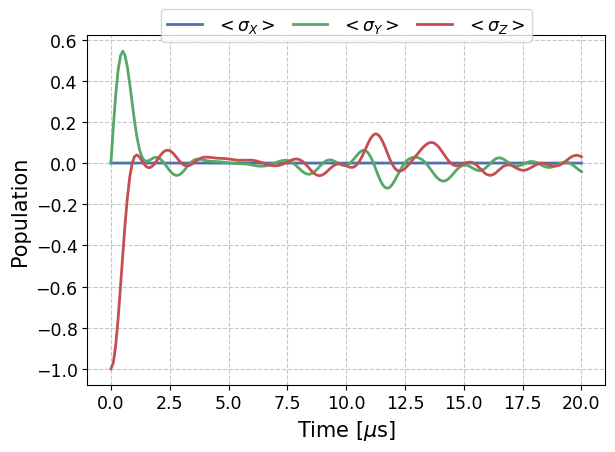

In [13]:
fig, ax = plt.subplots()

idx = 5
ax.plot(t_list * 1e6, miri_list[idx][0], label=r'$<\sigma_X>$')
ax.plot(t_list * 1e6, miri_list[idx][1], label=r'$<\sigma_Y>$')
ax.plot(t_list * 1e6, miri_list[idx][2], label=r'$<\sigma_Z>$')

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=3, columnspacing=1, fontsize='small')
plt.show()

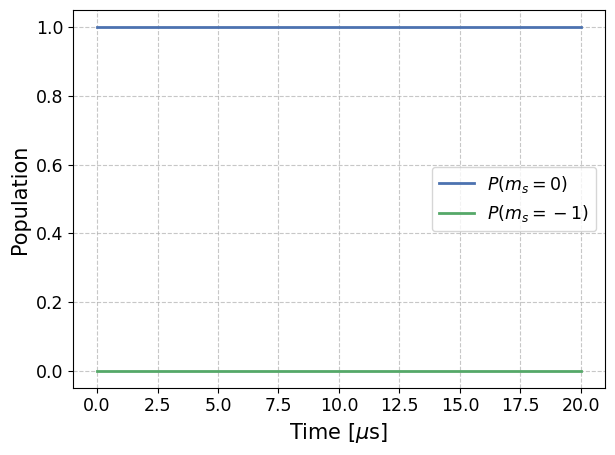

In [353]:
kwargs['env_approx_level'] = 'no_bath'

env = Environment(register_config, bath_configs, **kwargs)
env.pulse_seq = [20e-6]
env.old_state = hada * zm * hada

t_list = np.linspace(0, env.total_time, 200)
new_states = env.get_new_states(env.pulse_seq, t_list=t_list)

detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-0e-4) / (2*np.pi) - CONST["Nzz"] * CONST["m_N"]
detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]

new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)]

idx=1
fig, ax = plt.subplots()
ax.plot(t_list * 1e6, [state[0,0].real for state in new_states], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, [state[1,1].real for state in new_states], label=r'$P(m_s=-1)$')
# ax.axvline(x= 1e6/(env.matrices[0][1, 1].real - detuning), color='k', alpha=0.7)

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()

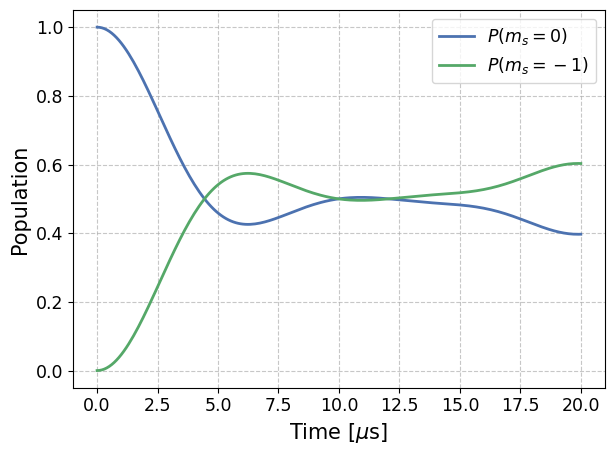

In [354]:
kwargs['env_approx_level'] = 'gCCE0'

env = Environment(register_config, bath_configs, **kwargs)
env.pulse_seq = [20e-6]
env.old_state = hada * zm * hada

t_list = np.linspace(0, env.total_time, 200)
new_states = env.get_new_states(env.pulse_seq, t_list=t_list)

detuning = CONST["D_gs"] + CONST["gamma_e"] * (CONST["Bz"]-0e-4) / (2*np.pi) - CONST["Nzz"] * CONST["m_N"]
detuning_gates = [q.Qobj( np.array([[1, 0], [0, np.e**(1j*2*np.pi*detuning*t) ]]) ) for t in t_list]

new_states = [hada *detuning_gate * state * detuning_gate.dag() * hada for state, detuning_gate in zip(new_states, detuning_gates)]

idx=1
fig, ax = plt.subplots()
ax.plot(t_list * 1e6, [state[0,0].real for state in new_states], label=r'$P(m_s=0)$')
ax.plot(t_list * 1e6, [state[1,1].real for state in new_states], label=r'$P(m_s=-1)$')
# ax.axvline(x= 1e6/(env.matrices[0][1, 1].real - detuning), color='k', alpha=0.7)

ax.set_ylabel('Population')
ax.set_xlabel(r'Time [$\mu$s]' )
ax.legend()
plt.show()